# Settings

## Imports

In [96]:
import sys,tweepy,csv,re, requests, json
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import os, time, re
import plotly.express as px

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import string
from nltk.stem import PorterStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gustavo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Configs

In [3]:
import warnings

# Suppressing the warnings
warnings.filterwarnings('ignore') 

#Changing dir
folder = 'ML'
try:
    os.chdir(f'{os.getcwd()}/{folder}')
except:
    dir = os.getcwd().replace(os.getcwd().split('/')[-1], folder)
    os.chdir(dir)

# Getting Twitter

## API

In [4]:
#token
config = dotenv_values(".env")
bearer_token = config['BEARER_TOKEN']

#connections
auth = tweepy.OAuth2BearerHandler({bearer_token})
api = tweepy.API(auth)




def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
    #print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

def get_tweet_v1(query, max_n):
    search_url = 'https://api.twitter.com/2/tweets/search/recent'
    tweets_dt = pd.DataFrame()

    print(f'Getting tweets...')

    try:
        # Querying the API
        json_response = connect_to_endpoint(search_url, query)
        
        try:
            tweets_dt = pd.DataFrame.from_dict(json_response['data'])
            
            try:
                n_token = json_response['meta']["next_token"]
                n = 0
                while n_token != 0 | n < max_n:
                    print(f'Next Token: {n} \n {n_token}')
                    query_next = query
                    query_next['next_token'] = n_token
                    json_response = connect_to_endpoint(search_url, query_next)
                    tweets_n = pd.DataFrame.from_dict(json_response['data'])
                    tweets_dt = pd.concat([tweets_dt,tweets_n], ignore_index=True)

                    n += 1
                    n_token = json_response['meta']["next_token"]
                
            except:
                print('Error to get next page')
        
        except:
            print('Error to get data from Json File')     

    except:
        print('Error to querying API')
        
    return tweets_dt


## Countries

Getting up to 1000 tweets each country

In [5]:
countries = ['Austria', 'Belgium', 'Bulgaria', 'Cyprus', 'Czechia', 'Denmark', 'Finland', 'France', 'Germany', 'Hungary',
        'Ireland', 'Italy', 'Latvia', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Spain','Sweden', 'Europe', 'UK']

filename = 'tweets_agri_2k.bz2'

if os.path.exists(filename) == False: 
    for c in countries:

        q = {
        'query': f'agriculture {c} -is:retweet',
        'max_results': 100,
        'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
        'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
        'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
        'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
        }

        t = get_tweet_v1(q, 10)
        t['country'] = c
        if c == countries[0]:
            tweets = t
        else:
            tweets = pd.concat([tweets, t], ignore_index=True)

    tweets.to_csv(filename, index=False,compression='bz2')
    print(f'File with {len(tweets)} saved.')

else:
    create_dt = time.strftime("%d/%m/%Y %H:%M:%S",time.strptime(time.ctime(os.path.getmtime(filename))))
    print(f'Reading {filename}, created at {create_dt}')
    tweets = pd.read_csv(filename)
    print(f'File with {len(tweets)} Tweets')
    

tweets.sample()

Reading tweets_agri_2k.bz2, created at 06/01/2023 01:49:21
File with 2126 Tweets


,public_metrics,conversation_id,text,reply_settings,lang,author_id,edit_history_tweet_ids,created_at,id,in_reply_to_user_id,referenced_tweets,country,geo
188,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1609937122697396228,Très largement mérité d'être au top 10 !\n#agr...,everyone,fr,3377884540,['1609937122697396228'],2023-01-02T15:38:15.000Z,1.609937e+18,NaN,NaN,France,NaN


# Clean Your Text Data

## Worlds extractions

In [6]:
def clean_tweet(x, link, keyword, usernames):
    list_of_lists =[]
    if link == True:
        list_of_links = []
        words = x.split(' ')
        for word in words:
            if re.search('http', word):
                list_of_links.append(re.split("\W+",word.lower()))
        if len(list_of_links) > 0:
            list_of_lists.append(list_of_links[0])
    
    if keyword == True:
        list_of_keywords = []
        words = x.split()
        for word in words:
            if word.startswith('#'):
                list_of_keywords.append(word)
        if len(list_of_keywords) > 0:
            list_of_lists.append(list_of_keywords)
            
    if usernames == True:
        list_of_usernames = []
        words = x.split()
        for word in words:
            if word.startswith('@'):
                list_of_usernames.append(word.lower().replace('@',''))
        if len(list_of_usernames) > 0:
            list_of_lists.append(list_of_usernames)
    
    return  [item for sublist in list_of_lists for item in sublist]

        
# keyword extraction from tweets
def get_keywords(x):
    list_of_keywords = []
    words = x.split()
    for word in words:
        if word.startswith('#'):
            list_of_keywords.append(word)
    return list_of_keywords


In [7]:
tweets = tweets[tweets.lang == 'en']
tweets = tweets.reset_index(drop = True)

In [8]:
list_of_lists = tweets['text'].apply(lambda tweet : clean_tweet(tweet, link = True, keyword = False, usernames = True))
rem_list = [item for sublist in list_of_lists for item in sublist]

tweets['text_c'] = tweets['text'].apply( lambda tweet : ' '.join([word for word in re.split("\W+",tweet) if word.lower() not in rem_list]))

In [9]:
tweets['keywords'] = tweets['text'].apply( lambda tweet : get_keywords(tweet) )

In [10]:
tweets.sample(2)

,public_metrics,conversation_id,text,reply_settings,lang,author_id,edit_history_tweet_ids,created_at,id,in_reply_to_user_id,referenced_tweets,country,geo,text_c,keywords
866,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1603088742792761346,@HvolkaMarek @PucakMichele @LauraFKALolly No. ...,everyone,en,1526615130967928832,['1604518773892972545'],2022-12-18T16:47:40.000Z,NaN,8.415532e+08,"[{'type': 'replied_to', 'id': '160451782502426...",Europe,NaN,No When you need a truck you need a truck Of c...,[]
22,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1610555100279472130,@stainless231 No programs in agriculture in Fi...,everyone,en,721743171760226304,['1610910981370318849'],2023-01-05T08:08:01.000Z,1.610911e+18,1.120502e+09,"[{'type': 'replied_to', 'id': '161055510027947...",Finland,NaN,No programs in in Finland I have been searchin...,[]


In [65]:
n =45
print('OLD: ', tweets['text'][n], '\n')
print('NEW: ', tweets['text_c'][n])

OLD:  @EU_Commission @EUInterpreters Cpec rpec projects 🌊💦 electric gas dam sugar steel mill cloth machines agriculture machines hospital machines plane train car bus made machines workshop made companies cheap rupees half rupees 🎁🎁 gift 🎁 china japan korea german Honduras Astonia Salvador France 

NEW:  Cpec rpec projects electric gas dam sugar steel mill cloth machines machines hospital machines plane train car bus made machines workshop made companies cheap rupees half rupees gift china japan korea german Honduras Astonia Salvador France


In [47]:
len(tweets)

1409

## PorterStemmer

In [12]:
# Store the stopwords into the object named as "stop_words"
stop_words = stopwords.words('english')

# Store the string.punctuation into an object punct
punct = string.punctuation

# Initialise an object using a method PorterStemmer
stemmer = PorterStemmer()

In [67]:
def stemming(df, text_col, name_new_col):
    # Store the column of the dataframe named as "text"
    X = df[text_col]
    cleaned_data=[]
    # For loop from first value to length(X), ^a-zA-Z means include small and capital case letters
    for i in range(len(X)):
        text = re.sub('[^a-zA-Z]', ' ', X.iloc[i])
        text = text.lower().split()
        text = [stemmer.stem(word) for word in text if (word not in stop_words) and (word not in punct)]
        text = ' '.join(text)
        df.loc[ i ,name_new_col] = text
    print('Stemmer done!')

In [70]:
stemming(tweets, 'text_c', 'text_ps')

Stemmer done!


In [75]:
n =0
print('ORIGINAL: ', tweets['text'][n], '\n')
print('CLEAN: ', tweets['text_c'][n], '\n')
print('STEMMER: ', tweets['text_ps'][n])

ORIGINAL:  Academic spam is great! I've been invited to be a keynote speaker at a Plant Biology conference in Vienna 😂
95% sure it's spam, but tempted to say yes! Imagine it's legit and I find myself in Austria, speaking to a room of stunned plant experts about WWII Scottish agriculture... 

CLEAN:  Academic spam is great I ve been invited to be a keynote speaker at a Plant Biology conference in Vienna 95 sure it s spam but tempted to say yes Imagine it s legit I myself in Austria speaking to a room of stunned plant experts about WWII Scottish 

STEMMER:  academ spam great invit keynot speaker plant biolog confer vienna sure spam tempt say ye imagin legit austria speak room stun plant expert wwii scottish


## Sentiment Analyzes

TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. [link](https://textblob.readthedocs.io/en/dev/index.html)

In [16]:
tweets.sample(2)

,public_metrics,conversation_id,text,reply_settings,lang,author_id,edit_history_tweet_ids,created_at,id,in_reply_to_user_id,referenced_tweets,country,geo,text_c,keywords,text_ps
389,"{'retweet_count': 16, 'reply_count': 2, 'like_...",1609844000537866242,"""If the US is still ruthlessly protecting Micr...",everyone,en,1105230434487685121,['1609844000537866242'],2023-01-02T09:28:13.000Z,1.609844e+18,NaN,NaN,Europe,NaN,US is still ruthlessly protecting Microsoft Ap...,[],us still ruthlessli protect microsoft appl hua...
581,"{'retweet_count': 0, 'reply_count': 3, 'like_c...",1610357401068118016,@eastcoaststoat Please tell me you realise tha...,everyone,en,1179140638031450115,['1610418012955283456'],2023-01-03T23:29:09.000Z,1.610418e+18,316758337.0,"[{'type': 'replied_to', 'id': '161041345691767...",UK,NaN,Please tell me you realise that all monies rai...,[],pleas tell realis moni rais scotland vat ga oi...


In [17]:
for i in tweets.index:
    text = tweets.loc[i,'text_ps']
    tweets.loc[i, 'TextBlob'] = TextBlob(text).sentiment.polarity
    #print(TextBlob(text).sentiment.polarity)
    tweets.loc[i, 'Vader'] = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    #print(SentimentIntensityAnalyzer().polarity_scores(text)['compound'], '\n')
    
tweets.sample(2)

,public_metrics,conversation_id,text,reply_settings,lang,author_id,edit_history_tweet_ids,created_at,id,in_reply_to_user_id,referenced_tweets,country,geo,text_c,keywords,text_ps,TextBlob,Vader
827,"{'retweet_count': 0, 'reply_count': 2, 'like_c...",1602710088900304897,"@twit_grim That’s by value, not by calories. B...",everyone,en,1376683815024922624,['1605519899555659778'],2022-12-21T11:05:47.000Z,NaN,2.781786e+09,"[{'type': 'replied_to', 'id': '160544814875066...",Europe,NaN,That s by value not by calories By that Europe...,[],valu calori european look good addit cheap ene...,0.366667,0.4404
323,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1610913849791619072,Webinar Jan 13th on Horizon Europe calls targe...,everyone,en,412928559,['1610913849791619072'],2023-01-05T08:19:25.000Z,1.610914e+18,NaN,NaN,Europe,NaN,Webinar Jan 13th on Horizon calls targeting Ch...,[],webinar jan th horizon call target chines part...,0.000000,0.0000


In [76]:
for i in tweets.index:
    text = tweets.loc[i,'text_c']
    tweets.loc[i, 'TextBlob_c'] = TextBlob(text).sentiment.polarity
    #print(TextBlob(text).sentiment.polarity)
    tweets.loc[i, 'Vader_c'] = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    #print(SentimentIntensityAnalyzer().polarity_scores(text)['compound'], '\n')
    
for i in tweets.index:
    text = tweets.loc[i,'text']
    tweets.loc[i, 'TextBlob_o'] = TextBlob(text).sentiment.polarity
    #print(TextBlob(text).sentiment.polarity)
    tweets.loc[i, 'Vader_o'] = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    #print(SentimentIntensityAnalyzer().polarity_scores(text)['compound'], '\n')
    
tweets.sample(2)

,public_metrics,conversation_id,text,reply_settings,lang,author_id,edit_history_tweet_ids,created_at,id,in_reply_to_user_id,...,TextBlob,Vader,TextBlob_desc,Vader_desc,is_sarcastic_lsvc,is_sarcastic_lr,TextBlob_c,Vader_c,TextBlob_o,Vader_o
419,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",1608824515018231809,"@TheJalston @scat_tee @tina_21lol Yes, African...",everyone,en,1461207013191569408,['1609030663801569280'],2022-12-31T03:36:19.000Z,1.609031e+18,4.504356e+09,...,0.0,0.3612,neutral,positive,0,0,0.0,0.6369,0.0,0.6369
154,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1610656937099812864,"Post-Doctoral Researcher, APC Microbiome Irela...",everyone,en,1577505494,['1610656937099812864'],2023-01-04T15:18:33.000Z,1.610657e+18,NaN,...,0.0,0.0000,neutral,neutral,0,0,0.0,0.0000,0.0,0.0000


In [18]:
def get_polarity(df, col):

    polarity = 0
    neutral = 0
    wpositive = 0
    positive = 0
    spositive = 0
    wnegative = 0
    negative = 0
    snegative = 0
     
    for t in df.index:
        
        v = df.loc[t, col]
        polarity += v  # adding up polarities to find the average later

        if (v == 0):  # adding reaction of how people are reacting to find average later
            neutral += 1
            desc = 'neutral'
        elif (v > 0 and v <= 0.3):
            wpositive += 1
            desc ='weak_positive'
        elif (v > 0.3 and v <= 0.6):
            positive += 1
            desc = 'positive'
        elif (v > 0.6 and v <= 1):
            spositive += 1
            desc = 'strong_positive'
        elif (v > -0.3 and v <= 0):
            wnegative += 1
            desc = 'weak_negative'
        elif (v > -0.6 and v <= -0.3):
            negative += 1
            desc = 'negative'
        elif (v > -1 and v <= -0.6):
            snegative += 1
            desc = 'strong_negative'
         
        df.loc[t, f'{col}_desc'] = desc
        

    return {'polarity_sum':polarity,
            'polarity_mean':(polarity / len(df)),
            'neutral':neutral,
            'strong_positive':spositive,
            'positive':positive,
            'weak_positive':wpositive,
            'weak_negative':wnegative,
            'negative':negative,
            'strong_negative':snegative}




In [19]:
get_polarity(tweets,'TextBlob')

{'polarity_sum': 116.520942927443,
 'polarity_mean': 0.08269761740769553,
 'neutral': 557,
 'strong_positive': 42,
 'positive': 153,
 'weak_positive': 430,
 'weak_negative': 183,
 'negative': 38,
 'strong_negative': 4}

In [77]:
get_polarity(tweets,'TextBlob_o')

{'polarity_sum': 178.88707275132285,
 'polarity_mean': 0.1269603071336571,
 'neutral': 322,
 'strong_positive': 36,
 'positive': 244,
 'weak_positive': 586,
 'weak_negative': 187,
 'negative': 30,
 'strong_negative': 3}

In [78]:
get_polarity(tweets,'TextBlob_c')

{'polarity_sum': 145.64600258207412,
 'polarity_mean': 0.1033683481774834,
 'neutral': 376,
 'strong_positive': 37,
 'positive': 182,
 'weak_positive': 570,
 'weak_negative': 207,
 'negative': 32,
 'strong_negative': 4}

In [20]:
get_polarity(tweets,'Vader')

{'polarity_sum': 215.27659999999992,
 'polarity_mean': 0.1527867991483321,
 'neutral': 441,
 'strong_positive': 206,
 'positive': 355,
 'weak_positive': 136,
 'weak_negative': 87,
 'negative': 121,
 'strong_negative': 63}

In [80]:
get_polarity(tweets,'Vader_o')

{'polarity_sum': 304.66490000000016,
 'polarity_mean': 0.21622775017743093,
 'neutral': 281,
 'strong_positive': 404,
 'positive': 284,
 'weak_positive': 109,
 'weak_negative': 99,
 'negative': 120,
 'strong_negative': 112}

In [79]:
get_polarity(tweets,'Vader_c')

{'polarity_sum': 283.40110000000084,
 'polarity_mean': 0.20113633782824758,
 'neutral': 292,
 'strong_positive': 323,
 'positive': 350,
 'weak_positive': 131,
 'weak_negative': 106,
 'negative': 110,
 'strong_negative': 97}

In [21]:
tweets.sample()

,public_metrics,conversation_id,text,reply_settings,lang,author_id,edit_history_tweet_ids,created_at,id,in_reply_to_user_id,referenced_tweets,country,geo,text_c,keywords,text_ps,TextBlob,Vader,TextBlob_desc,Vader_desc
175,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1610202847336972289,Mainstream media appears to be more interested...,everyone,en,1432523702676037638,['1610202847336972289'],2023-01-03T09:14:09.000Z,1.610203e+18,NaN,NaN,Ireland,NaN,Mainstream media appears to be in reporting on...,[],mainstream media appear report agricultur news...,0.0,0.0,neutral,neutral


In [92]:
##Checking Twitters

n = 1015
print('\nText Original:', tweets.loc[n, 'text'], '\n',
     '-------------------------------------------------------------------------------------------')
print('Text Clear:', tweets.loc[n, 'text_c'], '\n',
     '-------------------------------------------------------------------------------------------')

print('Text Steammed:', tweets.loc[n, 'text_ps'], '\n',
     '-------------------------------------------------------------------------------------------')

print('KeyWords:', tweets.loc[n, 'keywords'], '\n',
     '-------------------------------------------------------------------------------------------')

print('\nTextBlob')
print('Original: ',f"{tweets.loc[n, 'TextBlob_o']:,.3f}", tweets.loc[n, 'TextBlob_o_desc'])
print('Clean: ',f"{tweets.loc[n, 'TextBlob_c']:,.3f}", tweets.loc[n, 'TextBlob_c_desc'])
print('Stemmed: ',f"{tweets.loc[n, 'TextBlob']:,.3f}", tweets.loc[n, 'TextBlob_desc'])

print('\nVader')
print('Original: ', f"{tweets.loc[n, 'Vader_o']:,.3f}", tweets.loc[n, 'Vader_o_desc'])
print('Clean: ', f"{tweets.loc[n, 'Vader_c']:,.3f}", tweets.loc[n, 'Vader_c_desc'])
print('Stemmed: ', f"{tweets.loc[n, 'Vader']:,.3f}", tweets.loc[n, 'Vader_desc'])




Text Original: #Haryana one of most important #agricultural producers in #India. Discussed with @hafedharyana MD A. Srinivas how #German #technologies &amp; #solutions can support #farmers in #sustainable &amp; productive #agriculture - benefiting millions of farmers in the State. Many opportunities! https://t.co/bA0TCypjdm 
 -------------------------------------------------------------------------------------------
Text Clear: Haryana one of most important agricultural producers in India Discussed with MD A Srinivas how German technologies amp can in sustainable amp productive benefiting millions of in State Many opportunities 
 -------------------------------------------------------------------------------------------
Text Steammed: haryana one import agricultur produc india discuss md sriniva german technolog amp sustain amp product benefit million state mani opportun 
 -------------------------------------------------------------------------------------------
KeyWords: ['#Haryana'

In [204]:
def Count_Values(df, columns):
    for c in columns:
        if c == columns[0]:
            data = df[f'{c}'].value_counts().to_frame().reset_index()
        else:
            data = data.merge(tweets[f'{c}'].value_counts().to_frame().reset_index(), on=['index'])
    
    data = data.rename(columns={'index':'values'})
    return data

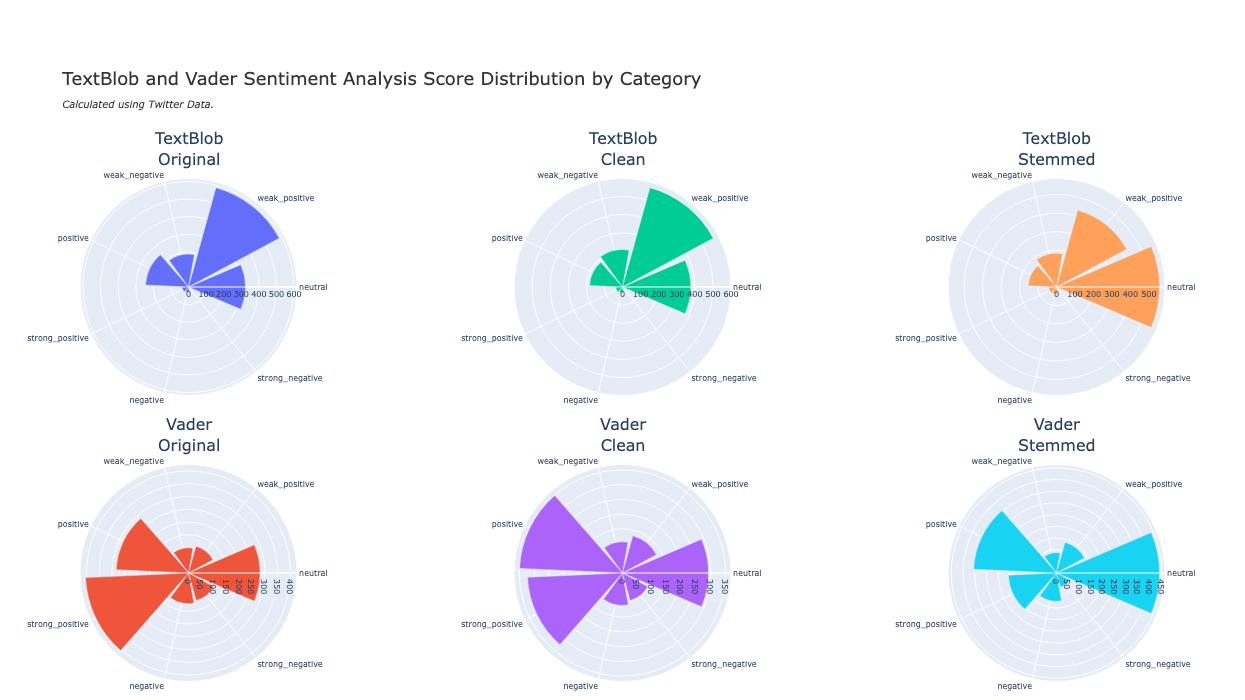

In [299]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

col = ['TextBlob_desc', 'Vader_desc', 'TextBlob_o_desc',
       'TextBlob_c_desc', 'Vader_c_desc', 'Vader_o_desc']

m = Count_Values(df = tweets,
                 columns = col)

title = f'TextBlob and Vader Sentiment Analysis Score Distribution by Category' \
        f'<br><span style="font-size:10px"><i>Calculated using Twitter Data.</span></i>'

fig = make_subplots(
    rows=2, cols=3,
    vertical_spacing=0.1,
    horizontal_spacing=0.2,
    specs=[[{"type": "barpolar"}, {"type": "barpolar"}, {"type": "barpolar"}],
          [{"type": "barpolar"}, {"type": "barpolar"}, {"type": "barpolar"}]],
    subplot_titles=("TextBlob<br>Original",
                    "TextBlob<br>Clean",
                    "TextBlob<br>Stemmed",
                   "Vader<br>Original", "Vader<br>Clean","Vader<br>Stemmed")

)

# Row 1 = TextBlob | Row 2 = Vader

#col 1 = Original
fig.add_trace(go.Barpolar(theta=m['values'], r=m['TextBlob_o_desc']),
              row=1, col=1)

fig.add_trace(go.Barpolar(theta=m['values'], r=m['Vader_o_desc']),
              row=2, col=1)


#col 2 = Clean
fig.add_trace(go.Barpolar(theta=m['values'], r=m['TextBlob_c_desc']),
              row=1, col=2)

fig.add_trace(go.Barpolar(theta=m['values'], r=m['Vader_c_desc']),
              row=2, col=2)

#col 3 = Stemmed
fig.add_trace(go.Barpolar(theta=m['values'], r=m['TextBlob_desc']),
              row=1, col=3)

fig.add_trace(go.Barpolar(theta=m['values'], r=m['Vader_desc']),
              row=2, col=3)


fig.update_layout(
    showlegend=False,
    font_size=8,
    title_font_size=18,
    title_text=title,
    title_font_color='#333333',
    width = 1200,
    height=700,
    plot_bgcolor='white',
    margin_t=170,
    margin_b=10)

fig.show()

Claramente há uma perda da intensidade na análises das ferramentas, classificando os textos de forma mais neutra após as fases de tratamento do texto, uma vez que estas ferramentas utilizam caracteres removidas para calcula a intensidade das emoções.

There is clearly a loss of intensity in the analysis of the tools, classifying texts more neutrally after the text treatment phases, since these tools use removed characters to calculate the intensity of emotions.

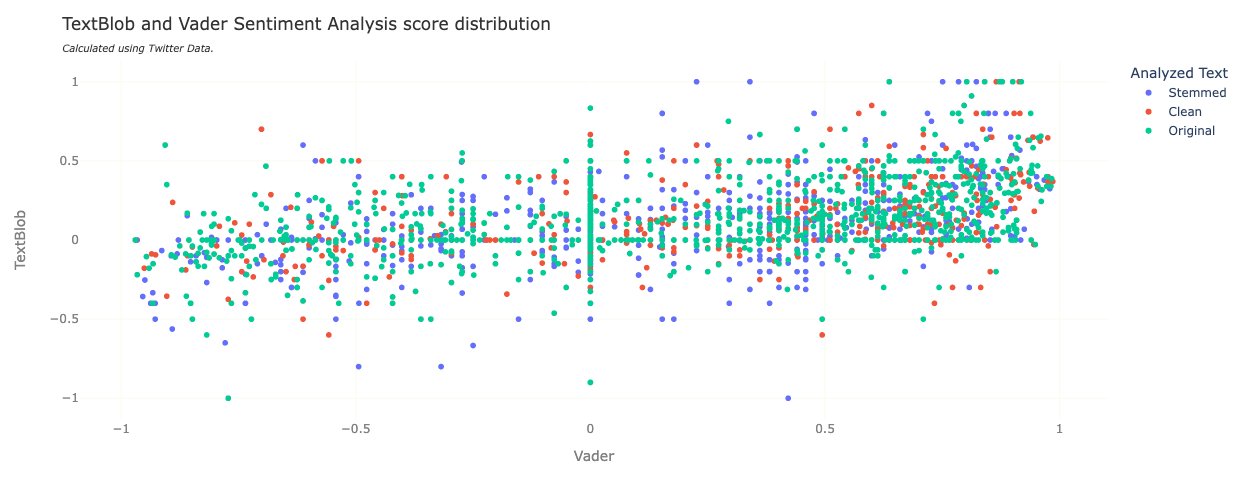

In [218]:

#Creating Df to plot
t = pd.melt(tweets.reset_index(), id_vars='index', value_vars=['TextBlob','TextBlob_c', 'TextBlob_o'])
v = pd.melt(tweets.reset_index(), id_vars='index', value_vars=['Vader_c','Vader','Vader_o'])

t = t.replace({'TextBlob' : 'Stemmed',
               'TextBlob_c' : 'Clean',
               'TextBlob_o' : 'Original'})
v = v.replace({'Vader' : 'Stemmed',
               'Vader_c' : 'Clean',
               'Vader_o' : 'Original'})

m = t.merge(v, how='inner', on=['index', 'variable'])
del t, v
m = m.drop('index', axis = 1).rename(columns={'value_x' : 'TextBlob', 'value_y':'Vader'})

m

title = f'TextBlob and Vader Sentiment Analysis score distribution' \
        f'<br><span style="font-size:10px"><i>Calculated using Twitter Data.</span></i>'

fig =px.scatter( y= m['TextBlob'], 
                x=m['Vader'],
               color = m['variable'])


fig.update_layout(
    showlegend=True,
    title_text=title,
    title_font_color='#333333',
    width = 1000,
    height=500,
    plot_bgcolor='white',
    #yaxis_visible=False,
    xaxis_title_font_color='grey',
    yaxis_title_font_color='grey',
    yaxis_color='grey',
    xaxis_color='grey',
    yaxis_title_text = 'TextBlob',
    xaxis_title_text = 'Vader',
    yaxis_gridcolor = '#F7FCF0',
    xaxis_gridcolor = '#F7FCF0',
    #xaxis_showgrid=True, 
    coloraxis_showscale=False,
    legend_title_text= "Analyzed Text")

Neste gráfico é possível ver a alteração da dispersão dos pontos de acordo com o processo de tratamento, quanto mais tratado os dados mais eles se acumulmam nos eixos 0 (neutro).

In this graph it is possible to see the change in the dispersion of the points according to the treatment process, the more treated the data the more they accumulate in the 0 (neutral) axes.

## Sarcasm

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

In [25]:
news = pd.read_csv('sarcasm_headlines.bz2')
news.sample()

,headline,is_sarcastic
591,dad shoots daughter while teaching her about g...,0


In [26]:
print(news.isnull().any(axis = 0))

headline        False
is_sarcastic    False
dtype: bool


In [27]:
stremming(news, 'headline', 'headline_ps')

Stremmer done!


In [28]:
news.sample(2)

,headline,is_sarcastic,headline_ps
25443,12 pieces of advice for president-elect trump,0,piec advic presid elect trump
4450,nation finds solace in knowledge candidates ta...,1,nation find solac knowledg candid take year li...


In [29]:
def create_features(df, col, max_feat):
    features = df[col]

    # vectorizing the data with maximum features
    tv = TfidfVectorizer(max_features = max_feat)
    features = list(features)
    features = tv.fit_transform(features).toarray()
    
    return features

TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction. Let’s take sample example and explore two different spicy sparse matrix before go into deep explanation 

In [30]:
features = create_features(news, 'headline_ps', 5000)
labels = news['is_sarcastic']

In [31]:
# getting training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.5, random_state = 0)

In [303]:
%%time
print('\nLinear Support Vector Classifier:')
lsvc = LinearSVC()
lsvc.fit(features_train, labels_train)
print('Train: ',lsvc.score(features_train, labels_train))
print('Test: ',lsvc.score(features_test, labels_test))


print('\nGaussian Naive Bayes:')
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print('Train: ',gnb.score(features_train, labels_train))
print('Test: ',gnb.score(features_test, labels_test))


print('\nLogistic Regression:')
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print('Train: ',lr.score(features_train, labels_train))
print('Test: ',lr.score(features_test, labels_test))


print('\nRandom Forest Classifier:')
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print('Train: ',rfc.score(features_train, labels_train))
print('Test: ',rfc.score(features_test, labels_test))


Linear Support Vector Classifier:
Train:  0.9092406769507264
Test:  0.7648820666417072

Gaussian Naive Bayes:
Train:  0.7633667814886925
Test:  0.6566080119805316

Logistic Regression:
Train:  0.8530777295192452
Test:  0.7728940471733433

Random Forest Classifier:
Train:  0.9850980979481804
Test:  0.7307375514788469
CPU times: user 46.3 s, sys: 5.32 s, total: 51.6 s
Wall time: 53.9 s


### Cross-Validation

#### KFold

k-Fold cross-validation is a technique that minimizes the disadvantages of the hold-out method. k-Fold introduces a new way of splitting the dataset which helps to overcome the “test only once bottleneck”.

In [33]:
%%time
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble

kf =KFold(n_splits=5, shuffle=True, random_state=42)


print('\nLinear Support Vector Classifier:')
score = cross_val_score(lsvc, features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')


Linear Support Vector Classifier:
Scores for each fold are: [0.77592662 0.79146387 0.77143392 0.78491202 0.77682082]
Average score: 0.78
CPU times: user 7.19 s, sys: 3.88 s, total: 11.1 s
Wall time: 11.1 s


In [34]:
%%time
print('\nGaussuan Naive Bayes:')
score = cross_val_score(gnb, features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')



Gaussuan Naive Bayes:
Scores for each fold are: [0.68962935 0.68831898 0.66847623 0.68775739 0.68807339]
Average score: 0.68
CPU times: user 14.1 s, sys: 12.7 s, total: 26.7 s
Wall time: 30.3 s


In [35]:
%%time

print('\nLogistic Regression:')
score = cross_val_score(lr, features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')



Logistic Regression:
Scores for each fold are: [0.785848   0.79801572 0.77873456 0.78172969 0.77925482]
Average score: 0.78
CPU times: user 1min 51s, sys: 3.36 s, total: 1min 54s
Wall time: 1min 3s


In [36]:
%%time

print('\nRandom Forest Classifier:')
score = cross_val_score(rfc, features, labels, cv= kf, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')


Random Forest Classifier:
Scores for each fold are: [0.74653688 0.74728566 0.73867465 0.73567952 0.73993634]
Average score: 0.74
CPU times: user 4min 40s, sys: 7.71 s, total: 4min 48s
Wall time: 4min 59s


### Learning Curve

Determines cross-validated training and test scores for different training set sizes.

In [37]:
def get_learning_curve(model, X, y, cv, model_name):
    print(f'Getting Learning Curve for {model_name}')
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X, 
                                                            y, 
                                                            cv=cv, 
                                                            scoring='accuracy',
                                                            n_jobs=-1,
                                                            train_sizes=np.linspace(0.01, 1.0, 10))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    print('Training Score:')
    print(f'Average: {"{:.2f}".format(train_scores.mean())}')
    print(f'Standard Deviation: {"{:.2f}".format(train_scores.std())}')

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    print('\nTest Score:')
    print(f'Average: {"{:.2f}".format(test_scores.mean())}')
    print(f'Standard Deviation: {"{:.2f}".format(test_scores.std())}')
    
    print('\n')
    
    plt.subplots(1, figsize=(7,5))
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title(f"Learning Curve for {model_name}")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

Getting Learning Curve for Linear Support Vector Classifier
Training Score:
Average: 0.93
Standard Deviation: 0.04

Test Score:
Average: 0.74
Standard Deviation: 0.05




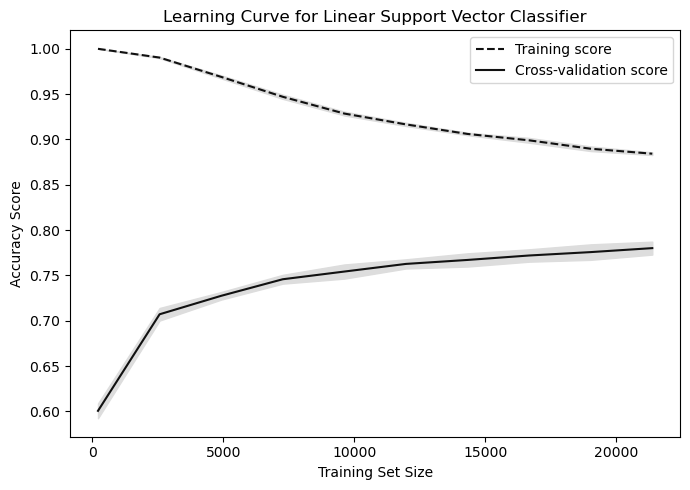

CPU times: user 810 ms, sys: 1.29 s, total: 2.1 s
Wall time: 1min 1s


In [38]:
%%time
get_learning_curve(model = lsvc,
               X = features,
               y = labels,
               cv = kf,
               model_name = 'Linear Support Vector Classifier')

Getting Learning Curve for Logistic Regression
Training Score:
Average: 0.87
Standard Deviation: 0.03

Test Score:
Average: 0.74
Standard Deviation: 0.06




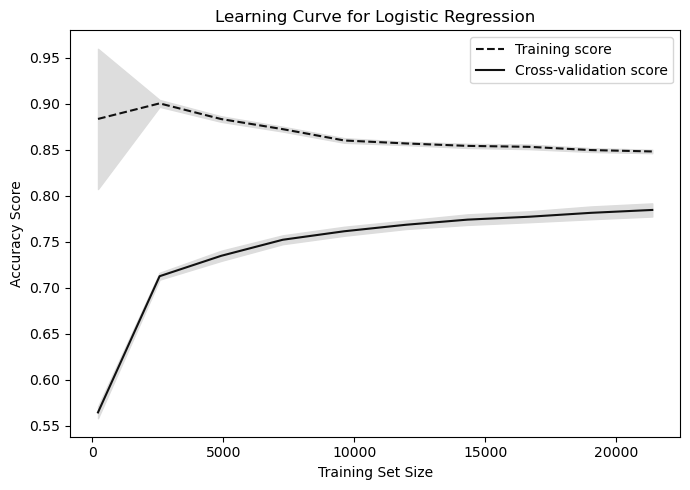

CPU times: user 1.11 s, sys: 1.74 s, total: 2.84 s
Wall time: 6min 7s


In [39]:
%%time
get_learning_curve(model = lr,
               X = features,
               y = labels,
               cv = kf,
               model_name = 'Logistic Regression')

Getting Learning Curve for Gaussuan Naive Bayes
Training Score:
Average: 0.81
Standard Deviation: 0.07

Test Score:
Average: 0.63
Standard Deviation: 0.04




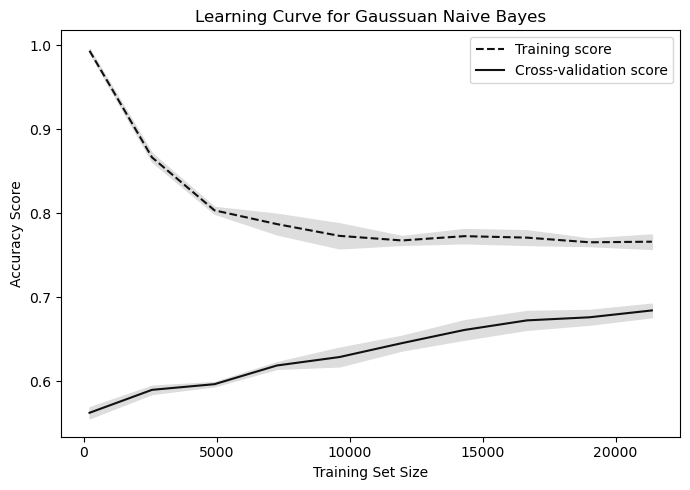

CPU times: user 1.04 s, sys: 2.34 s, total: 3.38 s
Wall time: 7min 40s


In [40]:
%%time
get_learning_curve(model = gnb,
               X = features,
               y = labels,
               cv = kf,
               model_name = 'Gaussuan Naive Bayes')

### Prev

In [41]:
prev = create_features(tweets, 'text_ps', 5000)

In [312]:
tweets['is_sarcastic_lsvc'] = lsvc.predict(prev)

In [313]:
tweets['is_sarcastic_lr'] = lr.predict(prev)

In [314]:
tweets.sample(4)

,public_metrics,conversation_id,text,reply_settings,lang,author_id,edit_history_tweet_ids,created_at,id,in_reply_to_user_id,...,is_sarcastic_lsvc,is_sarcastic_lr,TextBlob_c,Vader_c,TextBlob_o,Vader_o,TextBlob_o_desc,TextBlob_c_desc,Vader_c_desc,Vader_o_desc
1134,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1605703913671430145,Plan to boost productivity &amp; innovation in...,everyone,en,722758250811105280,['1605703913671430145'],2022-12-21T23:17:00.000Z,NaN,NaN,...,0,0,0.000000e+00,0.4939,0.000000,0.7003,neutral,neutral,positive,strong_positive
236,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1610659912517931008,"globally, less and less land is being used for...",everyone,en,1487871863216869381,['1610659912517931008'],2023-01-04T15:30:22.000Z,1.610660e+18,NaN,...,1,0,1.944444e-02,0.4122,0.019444,0.4122,weak_positive,weak_positive,positive,positive
700,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1609085646345314304,@JamesMelville There are loads of UK farmers d...,everyone,en,1593185868893888513,['1609304030127296521'],2022-12-31T21:42:34.000Z,1.609304e+18,1.593186e+18,...,0,0,5.551115e-17,0.5106,-0.075000,0.5562,weak_negative,weak_positive,positive,positive
125,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",1609894654140616706,Cpec rpec projects 🌊💦 electric gas dam sugar s...,everyone,en,1566407156576002050,['1609894654140616706'],2023-01-02T12:49:30.000Z,1.609895e+18,NaN,...,1,1,7.777778e-02,0.4404,0.077778,0.8910,weak_positive,weak_positive,positive,strong_positive


In [330]:
##Checking Twitters

n = 300

print('Text Original:\n', tweets.loc[n, 'text'], '\n',
     '-------------------------------------------------------------------------------------------')
print('Text Clear:\n', tweets.loc[n, 'text_c'], '\n',
     '-------------------------------------------------------------------------------------------')

print('Text Steammed:\n', tweets.loc[n, 'text_ps'], '\n',
     '-------------------------------------------------------------------------------------------')

print('KeyWords:\n', tweets.loc[n, 'keywords'], '\n',
     '-------------------------------------------------------------------------------------------')

print('\nCountry: ', tweets.loc[n, 'country'])

print('\nTextBlob')
print('Original: ',f"{tweets.loc[n, 'TextBlob_o']:,.3f}", tweets.loc[n, 'TextBlob_o_desc'])
print('Clean: ',f"{tweets.loc[n, 'TextBlob_c']:,.3f}", tweets.loc[n, 'TextBlob_c_desc'])
print('Stemmed: ',f"{tweets.loc[n, 'TextBlob']:,.3f}", tweets.loc[n, 'TextBlob_desc'])

print('\nVader')
print('Original: ', f"{tweets.loc[n, 'Vader_o']:,.3f}", tweets.loc[n, 'Vader_o_desc'])
print('Clean: ', f"{tweets.loc[n, 'Vader_c']:,.3f}", tweets.loc[n, 'Vader_c_desc'])
print('Stemmed: ', f"{tweets.loc[n, 'Vader']:,.3f}", tweets.loc[n, 'Vader_desc'])

print('\nSarcasm')
print('LSVC: ', tweets.loc[n, 'is_sarcastic_lsvc'])
print('LR: ', tweets.loc[n, 'is_sarcastic_lr'])


Text Original:
 A warm welcome to Sweden taking the EU Council Presidency today 🇪🇺🇸🇪.
I look forward to a constructive and successful cooperation in matters related to agriculture. #EU2023SE

Thank you 🇨🇿 Czech Council presidency @EU2022_CZ for your excellent work! #EU2022CZ https://t.co/d1Fpkaugo9 
 -------------------------------------------------------------------------------------------
Text Clear:
 A warm welcome to Sweden taking EU Council Presidency I look forward to a constructive successful cooperation in matters related to EU2023SE Thank you Czech Council presidency for your excellent work EU2022CZ 
 -------------------------------------------------------------------------------------------
Text Steammed:
 warm welcom sweden take eu council presid look forward construct success cooper matter relat eu se thank czech council presid excel work eu cz 
 -------------------------------------------------------------------------------------------
KeyWords:
 ['#EU2023SE', '#EU2022CZ']

In [343]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [415]:
def Plot_WordCloud(data, column_words, drop_word = [], min_df = .01, max_df = .6, figsize=[12,8]):

    vectorizer = TfidfVectorizer(stop_words='english', min_df = min_df, max_df = max_df) #ngram_range = (1,1)
    X = vectorizer.fit_transform(data[column_words])
    feature_names = vectorizer.get_feature_names()
    dense = X.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)


    #removing words
    
    for d in drop_word:
        try:
            df = df.drop(d , axis = 1)
        except:
            pass

    df = df.T
    df['total'] = df.sum(axis=1)

    print(f'Total of words: {len(df)}')

    wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', 
                          background_color="white", 
                          width=3000, 
                          height=2000, 
                          max_words=500
                         ).generate_from_frequencies(df['total'])

    plt.figure(figsize=[12,8])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off");

Total of words: 259


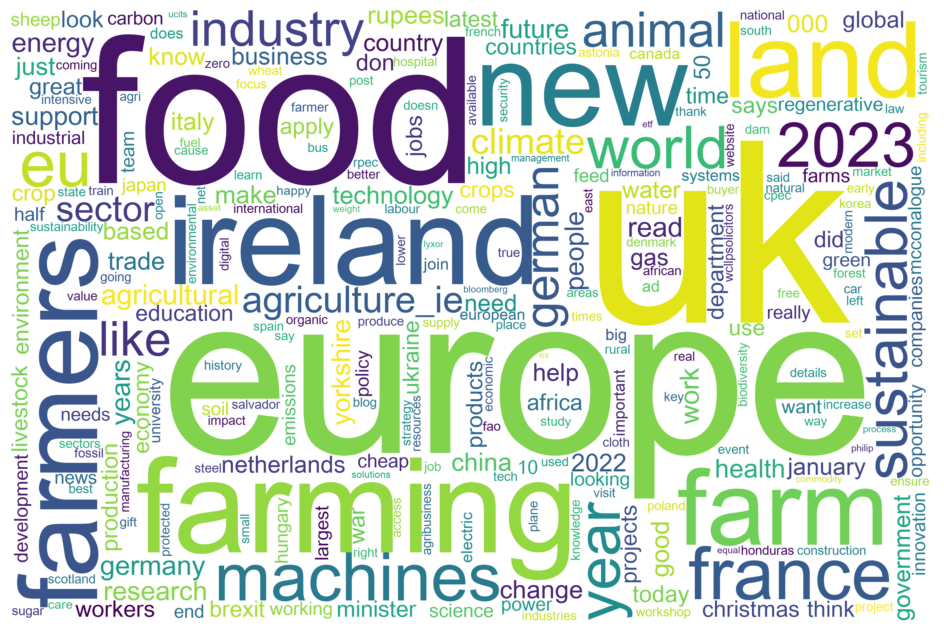

In [416]:
Plot_WordCloud(data = tweets,
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])

Total of words: 357


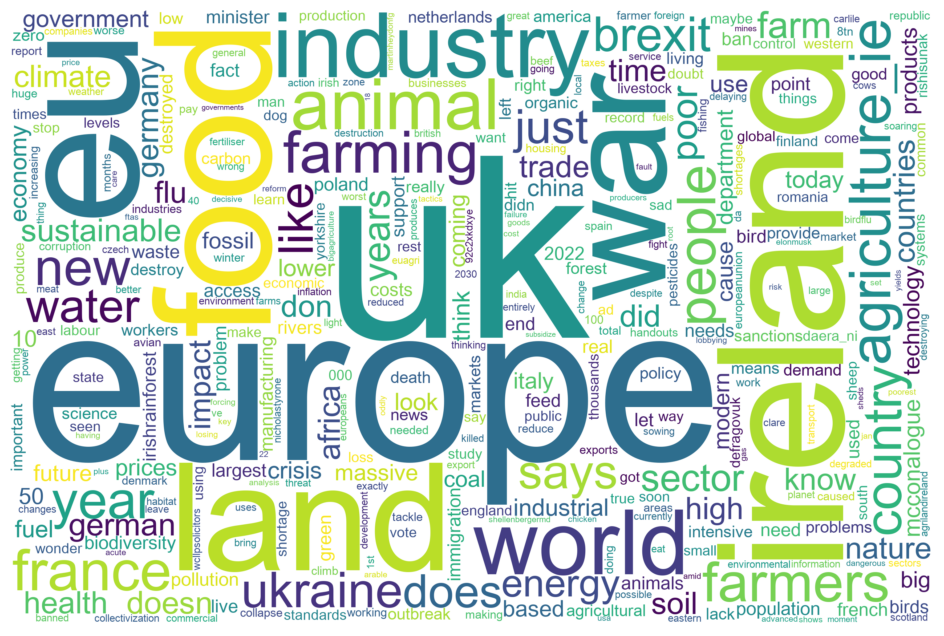

In [419]:
neg_sent = ['weak_negative','negative','strong_negative']

Plot_WordCloud(data = tweets[tweets['Vader_o_desc'].isin(neg_sent)],
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])

Total of words: 308


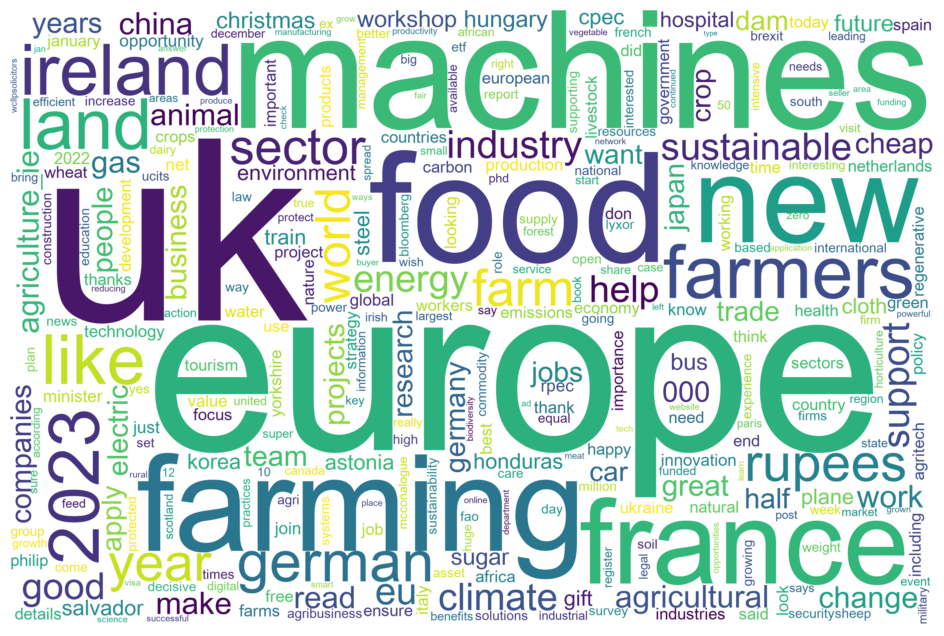

In [420]:
pos_sent = ['strong_positive','positive','weak_positive']
Plot_WordCloud(data = tweets[tweets['Vader_o_desc'].isin(pos_sent)],
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])

Total of words: 299


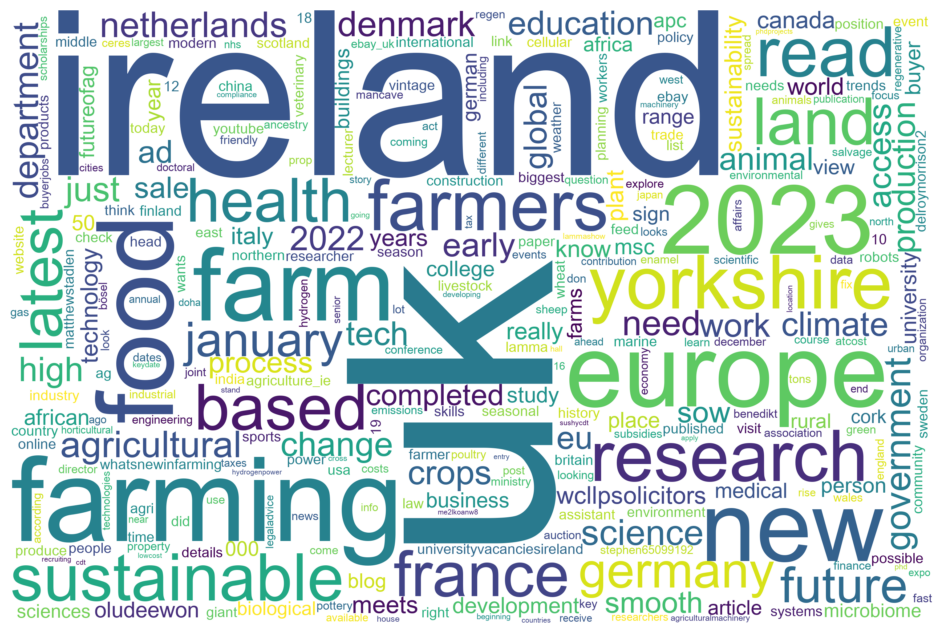

In [421]:
neu_sent = ['neutral']

Plot_WordCloud(data = tweets[tweets['Vader_o_desc'].isin(neu_sent)],
               column_words = 'text',
               drop_word = ['amp', 'https'],
              figsize=[13,8])